Using a single linear regression allows us to approximate and approximate the entire distribution, a map from values to indices, using only 2 parameters for the entire dataset -- that is, using $\mathcal{O}(1)$ memory, we can create an index structure.
However, we have also seen that using only a single linear regressor is not very accurate, with some predictions being on the order of 1000 indices off, which also negatively impacts query performance.
It stands to reason that we can afford to make our model complex if it can improve accuracy.

A key observation is that a single linear regressor assumes that that a linear approximation is accurate across the entire distribution, but this is not so. Let's take another look at our dataset.

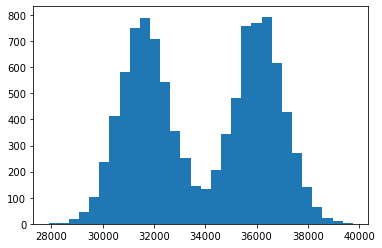

In [1]:
import numpy as np
import matplotlib.pyplot as plt

L = 10000
data = np.abs(np.random.normal(np.sqrt(10)*L, 0.1*L, size=L) \
    + 0.45*L*np.random.randint(2,size=L)).astype(int)

fig, ax = plt.subplots()
ax.hist(data, bins=30)

plt.show()

[]

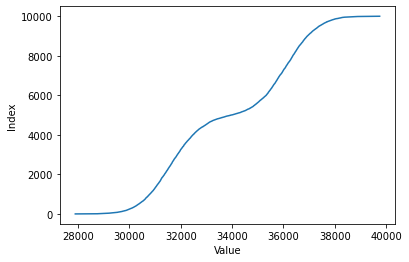

In [2]:
data.sort()

fig, ax = plt.subplots()
ax.plot(data, range(len(data)))
ax.set_xlabel('Value')
ax.set_ylabel('Index')
ax.plot()

Observe that the index distribution of our data is non-linear, and more importantly, the behavior of the distribution varies.
Most succinctly, at around a value of 31,000 to 32,500, the distribution is cocave down, but is about concave up to about 36,500.
It is optimistic for a singular linear regressor to encapsulate all of this behavior.
The most natural progression for a generalizable model is one that makes use of multiple linear regressors, for different parts of the distribution.
A linear regressor does the best it can for the input data.
By using multiple linear regressors, each regressor encapsulates a smaller subset of data, making its predictions more accurate since less variation is observed at a smaller level.
This is similar to using Newton's method for approximating differential equations.

We will first try using 10 linear regressors, each dedicated to $10\%$ of the values.

In [19]:
from sklearn.linear_model import LinearRegression

data = np.array(data)
idx = range(len(data))

regressors = []

length = len(data)
for i in range(10):
    start = int(i * length / 10)
    end = int((i + 1) * length / 10)

    X = np.array(data[start:end]).reshape(-1, 1)
    Y = idx[start:end]

    regr = LinearRegression()
    regr.fit(X, Y)

    regressors.append((X[-1], regr.predict))

We now have 10 regressor models, armed with an upper bound.
That is, our query strategy is to first identify which regressor model is appropiate, by seeing if the value is larger than the largest value the regressor has trained on, and then using said regressor to predict.

[]

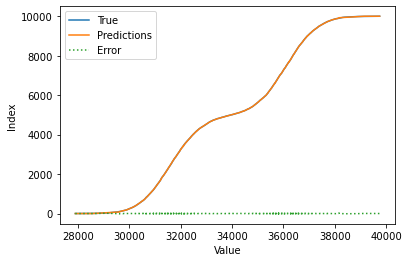

In [61]:
import models

def piecewisepredict(regressors):
    
    def inner(x):
        for up, predict in regressors:
            if x <= up:
                return predict([[x]])[0]
    
    return inner

pinchpredict = models.pinch_predict(data, piecewisepredict(regressors))

predictions = [pinchpredict(x) for x in data]
residuals = [x - i for i, x in enumerate(predictions)]

fig, ax = plt.subplots()
ax.plot(data, idx, label="True")
ax.plot(data, predictions, label="Predictions")
ax.plot(data, residuals, ':', label="Error")
ax.set_xlabel('Value')
ax.set_ylabel('Index')
ax.legend()
ax.plot()

This seems much better. Let's see what our worst error is.

In [30]:
display(max(map(abs, residuals)))

186.70558809452996

We can try more models, as well, such as 100 instead of 10.

[]

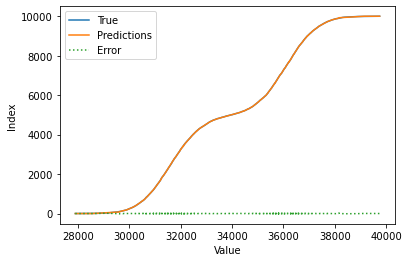

In [59]:
def model(data, numregressors):
    regressors = []

    length = len(data)
    for i in range(numregressors):
        start = int(i * length / numregressors)
        end = int((i + 1) * length / numregressors)

        X = np.array(data[start:end]).reshape(-1, 1)
        Y = idx[start:end]

        regr = LinearRegression()
        regr.fit(X, Y)

        regressors.append((X[-1], regr.predict))
    
    return regressors

regressors = model(data, 100)

pinchpredict = models.pinch_predict(data, piecewisepredict(regressors))
predictions = [pinchpredict(x) for x in data]
residuals = [x - i for i, x in enumerate(predictions)]

fig, ax = plt.subplots()
ax.plot(data, idx, label="True")
ax.plot(data, predictions, label="Predictions")
ax.plot(data, residuals, ':', label="Error")
ax.set_xlabel('Value')
ax.set_ylabel('Index')
ax.legend()
ax.plot()

In [32]:
display(max(map(abs, residuals)))

23.651786565693328

This is an improvement of about 5x.
It may also be worth considering this as a percentage.

In [34]:
display(max(map(abs, residuals)) / (max(data) - min(data)))

0.001993744125911939

With 100 linear regressors, we have a maximal error of about 0.2%.

Now we can consider the performance.

First, model construction time.

In [62]:
%%timeit

regressors = model(data, 10)

predict = models.pinch_predict(data, piecewisepredict(regressors))
bs = models.informed_bsearch(data, predict)
es = models.exponential_search(data, predict)

4.11 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
from BTrees.LLBTree import LLBTree

In [39]:
%%timeit
t = LLBTree()
t.update({int(x): 0 for x in data})

1.4 ms ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We again see a speed advantage for the B-Tree construction, which we again tenatively hypothesize is caused by the CPython speedup.

In [65]:
regressors = model(data, 10)

predict = models.pinch_predict(data, lambda x: int(piecewisepredict(regressors)(x)))
bs = models.informed_bsearch(data, predict)
es = models.exponential_search(data, predict)

In [67]:
%%timeit

for x in data:
    bs(x)

476 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%%timeit

for x in data:
    es(x)

460 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is slower than the B-tree.
Let us now consider more linear regressors.

In [69]:
regressors = model(data, 100)

predict = models.pinch_predict(data, lambda x: int(piecewisepredict(regressors)(x)))
bs = models.informed_bsearch(data, predict)
es = models.exponential_search(data, predict)

In [70]:
%%timeit

for x in data:
    bs(x)

717 ms ± 9.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%%timeit

for x in data:
    es(x)

740 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is worse performant, despite the accuracy increase.

Important to consider is that we fundamentally make no judgment calls about the distribution, besides uniform boundaries for determining where arbitrary cutoffs are.
This is not a great strategy, since uniform cutoffs are less informed on data; we obtain greater complexity as a consequence of model complexity.
Hence an important next step is to **inform the positioning of linear regressors.**
Further, we see that in spite of significant improvements to accuracy, the model actually performs slower.
This is due in part due to the search strategies; an informed binary search does not significantly improve from a guess, but exponential search does.
However, *binary search is already incredibly performant.*
Thus the linear search of our regressors, despite a linear search of only 10 elements, is a signifcant slow down, since 10 iterations of binary search cuts the search space by $2^{10}$, compared to $10$.